In [30]:
import numpy as np
from scipy import sparse
import operator

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [31]:
def calculate_pagerank(A_sparse, N, dangling_indices, m, max_iter=200, tol=1e-7):
    """
    Computes PageRank using the Power Method with Sparse Optimizations.
    
    Mathematical Logic:
    x_new = (1-m)*Ax + (1-m)*[Dangling_Correction] + m/N
    
    Args:
        A_sparse: The sparse link matrix (missing dangling connections).
        N: Total nodes.
        dangling_indices: List of nodes that have no outgoing links.
        m: Teleportation probability (1-m is the damping factor).
        
    Returns:
        tuple: (PageRank Vector, Iterations)
    """
    
    # 1. Initialization
    # Start with uniform probability distribution (1/N for everyone)
    x = np.full(N, 1.0/N)
    
    # 2. Teleportation Constant
    # This is the "m * s" part of the formula.
    # Since s is [1/N, 1/N...], this term is just the scalar m/N added to every node.
    teleport_contribution = m / N
    
    # Ensure dangling_indices is a numpy array for fast indexing
    if not isinstance(dangling_indices, np.ndarray):
        dangling_indices = np.array(dangling_indices)
        
    iterations = 0
    
    # --- POWER METHOD LOOP ---
    for k in range(max_iter):
        x_prev = x.copy()
        
        # Step A: Standard Matrix Multiplication
        # This calculates flow only from nodes that have existing links.
        Ax = A_sparse.dot(x_prev)
        
        # Step B: Implicit Dangling Node Handling
        # Total mass from dangling nodes lost.
        dangling_mass_sum = np.sum(x_prev[dangling_indices])
        
        # We redistribute this lost mass evenly to ALL nodes (1/N), 
        # applied with the damping factor (1-m).
        dangling_correction = (1 - m) * (dangling_mass_sum / N)
        
        # Step C: Combine Everything
        # 1. Flow from Links
        # 2. Flow from Dangling Patch
        # 3. Flow from Random Teleport
        x = (1 - m) * Ax + dangling_correction + teleport_contribution
        
        # Step D: Convergence Check (L1 Norm)
        diff = np.sum(np.abs(x - x_prev))
        iterations = k + 1
        
        if diff < tol:
            break
            
    return x, iterations

In [32]:
print("=============================================")
print("                 EXERCISE 4")
print("=============================================")

# Coefficients of the characteristic polynomial: 12*x^3 + 0*x^2 - 2*x - 1 = 0
# Order: [x^3, x^2, x^1, x^0]
coeffs = [12, 0, -2, -1]

# Compute the roots of the polynomial
roots = np.roots(coeffs)

real_components = roots.real 

print("All roots found:")
print(real_components)

real_roots_mask = np.isreal(roots) 
pure_real_roots = roots[real_roots_mask].real

# Filter to extract only the positive real root
lambda_val = pure_real_roots[pure_real_roots > 0][0]

print(f"The eigenvalue (positive real) is: {lambda_val:.5f}")

                 EXERCISE 4
All roots found:
[ 0.56135324 -0.28067662 -0.28067662]
The eigenvalue (positive real) is: 0.56135


In [33]:
print("=============================================")
print(" EXERCISE 12: PAGE WITHOUT BACKLINKS")
print("=============================================")

A_ex12_dense = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0, 0.2], 
    [1/3, 0.0, 0.0, 0.0, 0.0, 0.2], 
    [1/3, 0.5, 0.0, 0.5, 1.0, 0.2], 
    [1/3, 0.5, 0.0, 0.0, 0.0, 0.2], 
    [0.0, 0.0, 0.5, 0.0, 0.0, 0.2], 
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # Row Pg 6 (No backlinks -> Backlinks = 0)
])

A_ex12_sparse = sparse.csr_matrix(A_ex12_dense)

print("\n--- CASE A: Ranking with m=0.0 ---")

scores_A, iters_A = calculate_pagerank(A_ex12_sparse, 6, False, m=0.0, max_iter=1000)

results_A = list(zip(np.arange(1, 7), scores_A))
results_A_sorted = sorted(results_A, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_A_sorted:
    print(f"Page {page_id}: {score:.4f}")

print("\n--- CASE B: Ranking with m=0.15 ---")

scores_M, iters_M = calculate_pagerank(A_ex12_sparse, 6, False, m=0.15)

results_M = list(zip(np.arange(1, 7), scores_M))
results_M_sorted = sorted(results_M, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_M_sorted:
    print(f"Page {page_id}: {score:.4f}")

# ---------------------------------------------------------
# RESULTS
# ---------------------------------------------------------
print("\nCheck Page 6 (No Backlink):")
print(f"With m=0.00 -> Score: {scores_A[5]:.6f} (Should be 0)")
print(f"With m=0.15 -> Score: {scores_M[5]:.6f} (Minimum guaranteed = 0.15/6 = 0.025)")

 EXERCISE 12: PAGE WITHOUT BACKLINKS

--- CASE A: Ranking with m=0.0 ---
Page 3: 0.3673
Page 1: 0.2449
Page 5: 0.1837
Page 4: 0.1224
Page 2: 0.0816
Page 6: 0.0000

--- CASE B: Ranking with m=0.15 ---
Page 3: 0.3402
Page 1: 0.2312
Page 5: 0.1738
Page 4: 0.1350
Page 2: 0.0948
Page 6: 0.0250

Check Page 6 (No Backlink):
With m=0.00 -> Score: 0.000000 (Should be 0)
With m=0.15 -> Score: 0.025000 (Minimum guaranteed = 0.15/6 = 0.025)


In [34]:
print("=============================================")
print(" EXERCISE 13: DISCONNECTED SUBNETWORKS")
print("=============================================")

A_ex13_dense = np.array([
    [0.0,0.0,0.5,      0.0,0.0], 
    [1.0,0.0,0.5,      0.0,0.0], 
    [0.0,1.0,0.0,      0.0,0.0], 
    [0.0,0.0,0.0,      0.0,1.0], 
    [0.0,0.0,0.0,      1.0,0.0]  
])

print("Matrix A (5x5) constructed with two disconnected components.")
print("Group A: Pages 1-2-3 (Internal links only)")
print("Group B: Pages 4-5   (Ping-pong link)")

A_ex13_sparse = sparse.csr_matrix(A_ex13_dense)

print("\n--- Ranking Calculation (m=0.15) ---")
scores_13, iters_13 = calculate_pagerank(A_ex13_sparse, 5, False, m=0.15)

results_13 = list(zip(np.arange(1, 6), scores_13))
results_13_sorted = sorted(results_13, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_13_sorted:
    group = "Group A" if page_id <= 3 else "Group B"
    print(f"Page {page_id} ({group}): {score:.4f}")

# ---------------------------------------------------------
# RESULTS ANALYSIS
# ---------------------------------------------------------
sum_group_A = np.sum(scores_13[0:3]) 
sum_group_B = np.sum(scores_13[3:5]) 

print("\n--- Probability Distribution Analysis ---")
print(f"Total Probability Group A (3 pages): {sum_group_A:.4f}")
print(f"Total Probability Group B (2 pages): {sum_group_B:.4f}")

# Expected Ratios
expected_A = 3/5
expected_B = 2/5

print(f"Approximate Expected Ratio (3/5 vs 2/5):")
print(f"A (Expected ~{expected_A:.2f}): {sum_group_A:.4f}")
print(f"B (Expected ~{expected_B:.2f}): {sum_group_B:.4f}")


if np.isclose(sum_group_A, expected_A, atol=0.01):
    print("\n[SUCCESS] The PageRank distribution matches the theoretical size ratio!")
else:
    print("\n[WARNING] Discrepancy detected.")

 EXERCISE 13: DISCONNECTED SUBNETWORKS
Matrix A (5x5) constructed with two disconnected components.
Group A: Pages 1-2-3 (Internal links only)
Group B: Pages 4-5   (Ping-pong link)

--- Ranking Calculation (m=0.15) ---
Page 2 (Group A): 0.2384
Page 3 (Group A): 0.2327
Page 4 (Group B): 0.2000
Page 5 (Group B): 0.2000
Page 1 (Group A): 0.1289

--- Probability Distribution Analysis ---
Total Probability Group A (3 pages): 0.6000
Total Probability Group B (2 pages): 0.4000
Approximate Expected Ratio (3/5 vs 2/5):
A (Expected ~0.60): 0.6000
B (Expected ~0.40): 0.4000

[SUCCESS] The PageRank distribution matches the theoretical size ratio!


In [35]:
print("=============================================")
print("                 EXERCISE 14")
print("=============================================")

# 1. SETUP 
A = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0], 
    [1/3, 0.0, 0.0, 0.0, 0.0], 
    [1/3, 0.5, 0.0, 0.5, 1.0], 
    [1/3, 0.5, 0.0, 0.0, 0.0], 
    [0.0, 0.0, 0.5, 0.0, 0.0]  
])

m = 0.15          # Teleportation probability
N = 5             # Web size
S = np.full((N, N), 1/N) # Uniform teleportation matrix

# Formula (3.1)
M = (1 - m) * A + m * S

# 2. CALCULATION OF THE EXACT STATIONARY STATE (q)
# Calculated using eigenvectors to have a reference for the error
eigenvalues, eigenvectors = np.linalg.eig(M)
idx_q = np.argmin(np.abs(eigenvalues - 1.0))
q = np.real(eigenvectors[:, idx_q])
q = q / np.sum(q) # Normalization (Sum = 1)
q = q.reshape(-1, 1)

# 3. APPLICATION OF THE POWER METHOD 
# Initial probability vector x0 (All mass on Page 1)
x = np.array([[1.0], [0.0], [0.0], [0.0], [0.0]])

print(f"{'Iter (k)':<10} | {'L1 Error (e_k)':<20} | {'Ratio (e_k/e_k-1)':<20}")
print("-" * 60)

#initial error
prev_error = np.sum(np.abs(x - q))

for k in range(1, 51):
    x = M @ x  
    curr_error = np.sum(np.abs(x - q))
    ratio = curr_error / prev_error
    
    # Print the checkpoints required by the paper
    if k in [1, 5, 10, 50]:
        print(f"{k:<10} | {curr_error:<20.10f} | {ratio:<20.10f}")
    
    prev_error = curr_error

# 4. CALCULATION OF THE THEORETICAL PARAMETERS FROM THE PAPER
# Ergodicity Coefficient c(M)
# Formula: max_j | 1 - 2 * min_i M_ij |
min_entries_per_column = np.min(M, axis=0)
c_M = np.max(np.abs(1 - 2 * min_entries_per_column))

# Second Dominant Eigenvalue |lambda_2|
abs_eigenvalues = np.sort(np.abs(eigenvalues))[::-1]
lambda_2 = abs_eigenvalues[1]

print("-" * 60)
print(f"THEORETICAL RESULTS:")
print(f"Second Dominant Eigenvalue |lambda_2|:   {lambda_2:.6f}")
print(f"Ergodicity Coefficient c(M):  {c_M:.6f}")
print(f"\nCheck Proposition 4: |lambda_2| <= c(M) is {lambda_2 <= c_M}")
print(f"Check Convergence: Final ratio ({ratio:.4f}) tends to |lambda_2| ({lambda_2:.4f})")

                 EXERCISE 14
Iter (k)   | L1 Error (e_k)       | Ratio (e_k/e_k-1)   
------------------------------------------------------------
1          | 0.7819626529         | 0.5125208082        
5          | 0.0068714107         | 0.3227085474        
10         | 0.0003043717         | 0.5245287480        
50         | 0.0000000000         | 0.6114691824        
------------------------------------------------------------
THEORETICAL RESULTS:
Second Dominant Eigenvalue |lambda_2|:   0.611269
Ergodicity Coefficient c(M):  0.940000

Check Proposition 4: |lambda_2| <= c(M) is True
Check Convergence: Final ratio (0.6115) tends to |lambda_2| (0.6113)


                 EXERCISE 15
Second eigenvalue |lambda_2|: 0.6113
Theoretical limit (1-m):    0.8500
Error at iteration 50:      7.44e-13


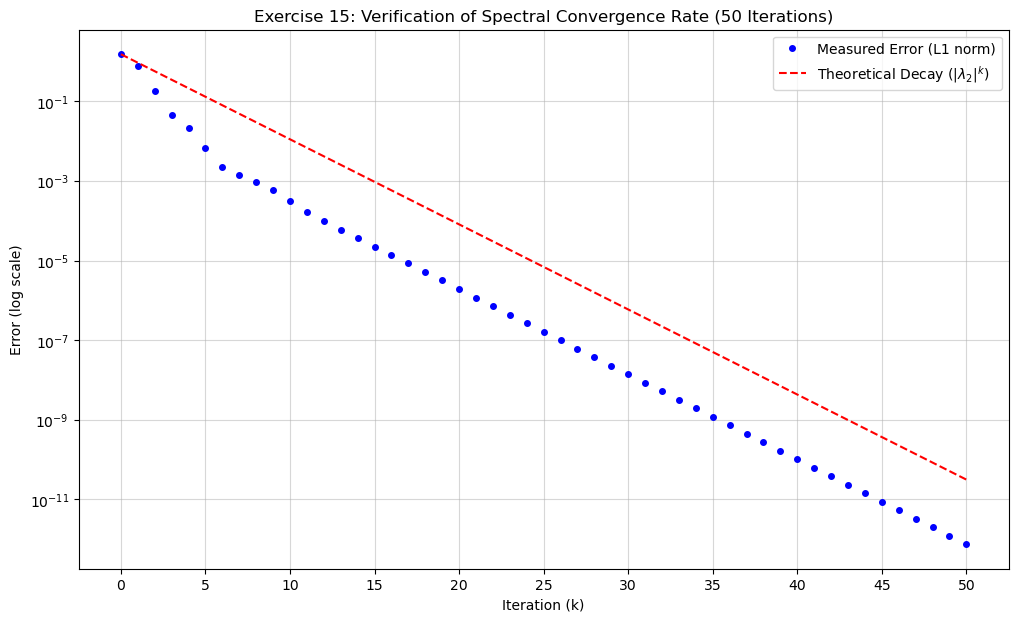

In [36]:
print("=============================================")
print("                 EXERCISE 15")
print("=============================================")

# The formal solution to Exercise 15 is the mathematical proof provided in the report.
# This script is used only to GENERATE THE PLOT to visually verify 
# that the convergence rate is indeed bounded by the second eigenvalue |lambda_2|.

# 1. SETUP 
A = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0], 
    [1/3, 0.0, 0.0, 0.0, 0.0], 
    [1/3, 0.5, 0.0, 0.5, 1.0], 
    [1/3, 0.5, 0.0, 0.0, 0.0], 
    [0.0, 0.0, 0.5, 0.0, 0.0]  
])
m = 0.15
N = 5
M = (1 - m) * A + m * np.full((N, N), 1/N)

# 2. CALCULATION OF EIGENVALUES AND STATIONARY STATE
eigenvalues, eigenvectors = np.linalg.eig(M)

# Sort eigenvalues by magnitude
abs_ev = np.sort(np.abs(eigenvalues))[::-1]
lambda_1 = abs_ev[0] # Should be 1.0
lambda_2 = abs_ev[1] # The second eigenvalue

# q is the eigenvector corresponding to lambda_1
idx_q = np.argmin(np.abs(eigenvalues - 1.0))
q = np.real(eigenvectors[:, idx_q])
q = (q / np.sum(q)).reshape(-1, 1)

# 3. POWER METHOD 
x = np.array([[1.0], [0.0], [0.0], [0.0], [0.0]])
errors = []
theoretical_decay = []

steps = range(51) 
initial_error = np.sum(np.abs(x - q))

for k in steps:
    curr_error = np.sum(np.abs(x - q))
    errors.append(curr_error)

    # Theoretical formula: e_k = e_0 * (lambda_2^k)
    theoretical_decay.append(initial_error * (lambda_2**k))

    x = M @ x

# 4. PLOT OF RESULTS
plt.figure(figsize=(12, 7))
plt.semilogy(steps, errors, 'ob', markersize=4, label='Measured Error (L1 norm)')
plt.semilogy(steps, theoretical_decay, 'r--', label=f'Theoretical Decay ($|\lambda_2|^k$)')

# --- CORREZIONE ASSE X ---
# Forza l'asse X a mostrare solo interi, con un intervallo di 5
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(np.arange(0, 51, 5)) 

plt.title('Exercise 15: Verification of Spectral Convergence Rate (50 Iterations)')
plt.xlabel('Iteration (k)')
plt.ylabel('Error (log scale)')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()

print(f"Second eigenvalue |lambda_2|: {lambda_2:.4f}")
print(f"Theoretical limit (1-m):    {1-m:.4f}")
print(f"Error at iteration 50:      {errors[-1]:.2e}")

plt.show()